In [5]:
from pathlib import Path
import requests
from matplotlib import pyplot
import numpy as np
import torch
import pickle
import gzip

In [6]:
DATA_PATH= Path("data")
PATH = DATA_PATH / "minist"
FILENAME = "mnist.pkl.gz"

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, 
                                                            encoding="latin-1")
    

(50000, 784)


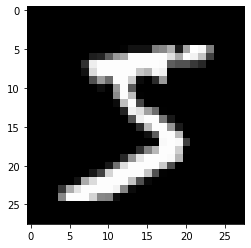

In [7]:
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)


In [8]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c =x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## 从0开始创建神经网络

In [9]:
import math

# 这里用Xavier初始化，通过乘以1/sqrt(n)来初始化权重

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)


In [10]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):  
    # @代表点积操作，我们将在上一批数据中调用我们的函数，进行前向传递
    return log_softmax(xb @ weights + bias)


In [11]:
bs = 64 # batch size
xb = x_train[0:bs] # a mini-batch from x
preds = model(xb) # predictions

print(preds[0], preds.shape)# preds tensor不仅包含tensor值，还包含一个梯度函数

tensor([-2.3052, -3.0463, -2.1733, -2.0120, -2.8581, -2.3335, -2.2406, -2.2200,
        -2.5760, -1.8340], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [12]:
# 利用负似然对数作为损失函数

def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [13]:
yb = y_train[0:bs]
print(loss_func(preds, yb))


tensor(2.2774, grad_fn=<NegBackward0>)


In [14]:
# 若数值最大的索引与目标值匹配，那么预测是正确的
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [15]:
print(accuracy(preds, yb))

tensor(0.1406)


我们现在可以运行一个训练循环。对于每一个迭代，我们将：
    1.选择一个小批量数据（大小为bs）
    2.使用该模型进行预测
    3.计算损失
    4.loss.backward()更新模型的梯度，在这里是指权重和偏置。

In [16]:
# 我们现在使用这些梯度来更新权重和偏置


lr = 0.5  # learning rate
epochs = 2 # how many epochs to train for

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
    
        loss.backward()
        with torch.no_grad(): 
        # 我们在上下文管理器中做这些事，因为我们不希望这些行为被记录在我们下一次计算梯度的时候
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

就这样，我们完全从开始创建并训练了一个最小的神经网络（在这种情况下，是一个逻辑回归，因为我们没有隐含层）

In [17]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0815, grad_fn=<NegBackward0>) tensor(1.)


#  使用Torch.nn.functional

我们将开始利用pytorch的nn类，使其更加简洁和灵活

In [18]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0815, grad_fn=<NllLossBackward0>) tensor(1.)


In [19]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [20]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3317, grad_fn=<NllLossBackward0>)


In [34]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

AttributeError: 'generator' object has no attribute 'grad'